<a href="https://colab.research.google.com/github/marcusnk237/ECG-Classification-COVID/blob/main/resvidnet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries and activate TPU
Importing the libraries and activate TPU to accelerate data processing and model training.

In [ ]:
#### Import libraries
import os
!pip install tensorflow_addons
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import logging
from random import choice
import random 
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Set random seed
np.random.seed(123)

### Metrics functions plot
Plotting Accuracy and loss curve, for train and validation data.
The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits validation data.
The training accuracy indicates how accurate the model is for the training data, while the validation accuracy indicates how accurate the model is for validation data.

In [ ]:
def metrics_plot(history, field, fn):
    def plot(data, val_data, best_index, best_value, title):
        plt.plot(range(1, len(data)+1), data, label='train')
        plt.plot(range(1, len(data)+1), val_data, label='validation')
        if not best_index is None:
            plt.axvline(x=best_index+1, linestyle=':', c="#777777")
        if not best_value is None:
            plt.axhline(y=best_value, linestyle=':', c="#777777")
        plt.xlabel('Epoch')
        plt.ylabel(field)
        plt.xticks(range(0, len(data), 20))
        plt.title(title)
        plt.legend()
        plt.show()

    data = history.history[field]
    val_data = history.history['val_' + field]
    tail = int(0.15 * len(data))

    best_index = fn(val_data)
    best_value = val_data[best_index]

    plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
    plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

### Confusion matrix plot
The function print and plot the confusion matrix.
It's a specific table layout that allows visualization of the performance of the model. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### ECG Signal classes
The class of the signals.
* Normal : Label for Normal ECG signal.
* HB : Label for abnormal ECG signal.
* PMI : Label for ECG signal of person with history of Myocardial Infarction.
* MI : Label for ECG signal of person with Myocardial Infarction.
* COVID : Label for ECG signal of person with COVID-19.

In [ ]:
classes=['Normal','HB','PMI', 'MI','COVID']

### Reading dataset and plot class repartition
Loading ECG dataset, and plotting data repartition per class.

In [ ]:
!pip install -q kaggle
########################

### Select kaggle.json file ##
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d marcjuniornkengue/ecg-covid-dataset
!unzip \*.zip  && rm *.zip

            0         1         2         3         4         5         6     \
0       0.075392  0.092356  0.108976  0.125430  0.141842  0.158058  0.173618   
1       0.837167  0.827709  0.813444  0.794425  0.770953  0.743516  0.712655   
2       1.024462  1.053443  1.082425  1.111406  1.140388  1.169369  1.205833   
3      -0.002551  0.002500  0.006554  0.009958  0.012505  0.014616  0.016229   
4      -0.172083 -0.635965  0.481577  0.622545  0.759162  0.884082  0.991492   
...          ...       ...       ...       ...       ...       ...       ...   
144995  0.007625  0.108382 -0.012685 -0.301772 -0.178479 -0.315465  0.002801   
144996 -0.029784 -0.039583 -0.045501 -0.047085 -0.044523 -0.038407 -0.029929   
144997 -0.153639 -0.145103 -0.136680 -0.128853 -0.122368 -0.117487 -0.113573   
144998 -0.405017 -0.379399 -0.357416 -0.338826 -0.323264 -0.310306 -0.299347   
144999  0.136669  0.130850  0.125224  0.119845  0.114857  0.110324  0.106119   

            7         8         9     .

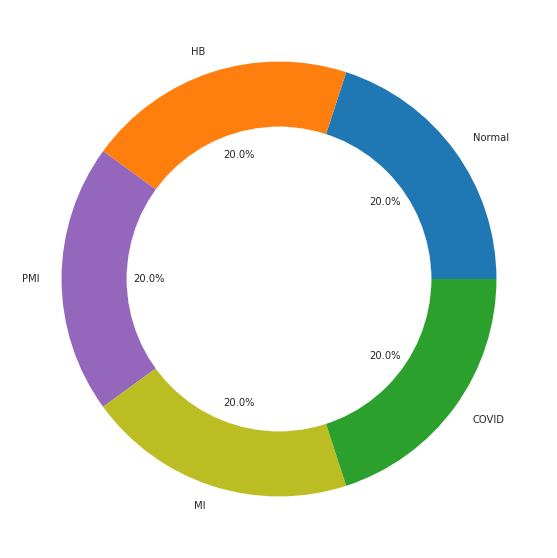

In [ ]:
## Load data
df=pd.read_csv('new_covid_ecg_dataset_balance_well_aug_29000.csv',header=None)
df.reset_index(drop=True, inplace=True)

## Get features and label
x=df.iloc[:,:-1].values # Signal data
y=df.iloc[:,-1].values  # Signal label

print(df) # Display dataset

## Data repartition per class 
per_class = df.iloc[:,-1].value_counts() 
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['Normal','HB','PMI', 'MI','COVID'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Train,test and validation split
The dataset is split into three subsets : 
* The train dataset, for training the model
* The validation dataset, to validate the model
* The test dataset, to evaluate the model

In [ ]:
y=y.astype(int) # Convert label into int
## Split into train and test
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=np.random.randint(1,1000, 1)[0], shuffle = True)
## Slip into test and validation
X_val, X_test, y_val, y_test  = train_test_split(X_val, y_val, test_size=0.5, random_state=np.random.randint(1,1000, 1)[0], shuffle = True)

## Expand data dimension for the Deep Learning Model
## Train data
X_train = np.expand_dims(X_train, -1)
y_train = np.expand_dims(y_train, -1)
## Validation data
X_val = np.expand_dims(X_val, -1)
y_val = np.expand_dims(y_val, -1)
## Test data
X_test = np.expand_dims(X_test, -1)
y_test = np.expand_dims(y_test, -1)


### The ResvidNet Model
The model is inspired by ResNet18. Residual block of ResNet network is enhance by adding:
* A Batch Normalization Layer, to normalize all datas for training
* More Conv1D layers with higher filters numbers, to learning signal features better,faster and increase accuracy
* Dropout Layers and regularization Layers , in order to prevent overfitting.
The input of the overall model is a Conv1D layer, follow by a Gaussian Noise Layer was also added, to make the model more robust.

In [ ]:

def ResVidNet(im_shape):
    ## The residual block of ResVidNet
    def residual_block(X, kernels, stride):
        out = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(X)
        
        out = keras.layers.Conv1D(kernels, stride,  kernel_regularizer=l2(0.001),padding='same')(out)
        out = keras.layers.ReLU()(out)
        out = keras.layers.Dropout(0.1)(out) 
        
        out = keras.layers.Conv1D(kernels, stride,  kernel_regularizer=l2(0.001),padding='same')(out)
        out = keras.layers.ReLU()(out)
        out = keras.layers.Dropout(0.1)(out) 
        
        out = keras.layers.Conv1D(kernels, stride,  kernel_regularizer=l2(0.001),padding='same')(out)
        out = keras.layers.ReLU()(out)
        out = keras.layers.Dropout(0.1)(out) 
        
        out = keras.layers.Conv1D(kernels, stride,  kernel_regularizer=l2(0.001),padding='same')(out)
        out = keras.layers.Dropout(0.1)(out) 
        out = keras.layers.ReLU()(out)
        
        out = keras.layers.Conv1D(kernels, stride, kernel_regularizer=l2(0.001) ,padding='same')(out)
        
        out = keras.layers.add([X, out])
        out = keras.layers.ReLU()(out)
        out = keras.layers.Dropout(0.1)(out)
        
        out = keras.layers.MaxPool1D(5, 2)(out)
        
        return out
    
    kernels = 256
    stride = 15


    inputs = keras.layers.Input(im_shape)
    X = keras.layers.Conv1D(kernels, stride)(inputs)
    X = keras.layers.GaussianNoise(0.01)(X)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(32, activation='relu')(X)
    X = keras.layers.Dense(32, activation='relu')(X)
    output = keras.layers.Dense(5, activation='softmax')(X)

    model = keras.Model(inputs=inputs, outputs=output)
    return model

### Setting the hyper-parameters, compiling and training the model

In [ ]:
### Hyper parameters
N=X_train.shape[0]
batch_size = 128 * tpu_strategy.num_replicas_in_sync
iterations = N/batch_size
step_size= 2 * iterations
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
with tpu_strategy.scope():
        resvidnet_model = ResVidNet((X_train.shape[1],1)) # Instanciate ResVidNet
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # Early stopping parameters
        save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True) # Model checkpoint parameters
        resvidnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Model compiling
        
## Model training
history = resvidnet_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=100, shuffle=False,callbacks=[save_best_weights,early_stopping])

Epoch 1/100
114/114 [==============================] - 111s 550ms/step - loss: 8.7619 - accuracy: 0.3297 - val_loss: 6.4351 - val_accuracy: 0.2626

Epoch 00001: val_loss improved from inf to 6.43506, saving model to weights.hdf5
Epoch 2/100
114/114 [==============================] - 20s 176ms/step - loss: 4.7061 - accuracy: 0.7122 - val_loss: 3.1062 - val_accuracy: 0.5754

Epoch 00002: val_loss improved from 6.43506 to 3.10622, saving model to weights.hdf5
Epoch 3/100
114/114 [==============================] - 20s 176ms/step - loss: 2.0886 - accuracy: 0.8101 - val_loss: 1.8911 - val_accuracy: 0.7021

Epoch 00003: val_loss improved from 3.10622 to 1.89108, saving model to weights.hdf5
Epoch 4/100
114/114 [==============================] - 20s 176ms/step - loss: 1.2292 - accuracy: 0.8821 - val_loss: 1.2292 - val_accuracy: 0.8633

Epoch 00004: val_loss improved from 1.89108 to 1.22917, saving model to weights.hdf5
Epoch 5/100
114/114 [==============================] - 20s 176ms/step - los

### Model evaluation
The model is evaluate using test data

In [ ]:
resvidnet_model.load_weights('weights.hdf5') # Loading model
X_covid_test = resvidnet_model.evaluate(X_test, y_test) # Evaluate model

454/454 [==============================] - 12s 21ms/step - loss: 0.1902 - accuracy: 0.9609


### Plotting Loss and Accuracy

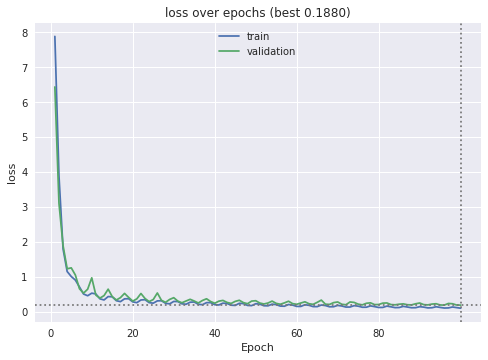

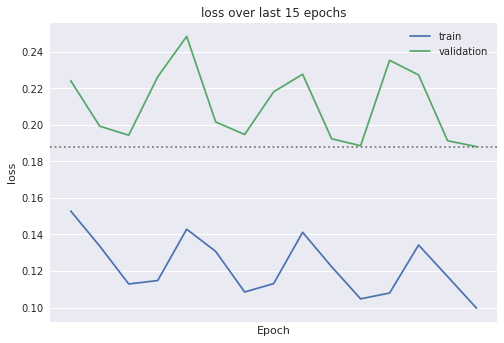

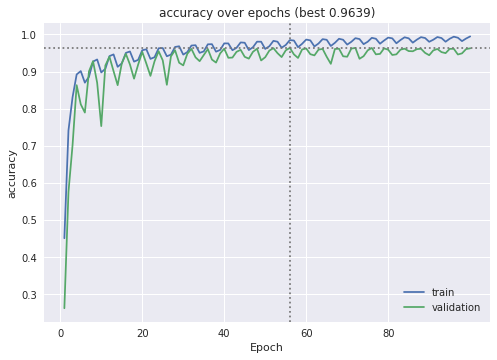

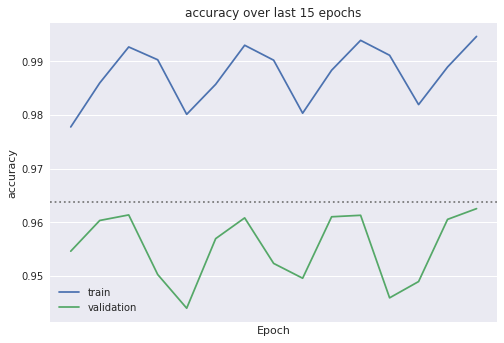

In [ ]:
metrics_plot(history, 'loss', lambda x: np.argmin(x))
metrics_plot(history, 'accuracy', lambda x: np.argmax(x))

### Plotting confusion matrix

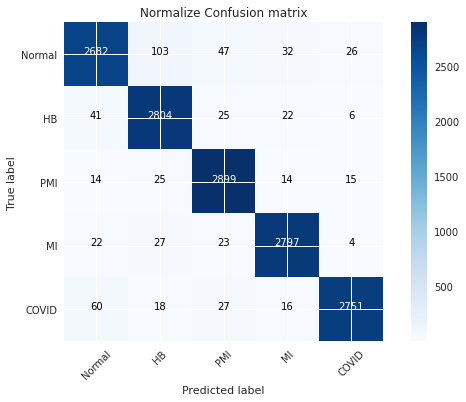

In [ ]:
# Class prediction overall
y_pred = tf.argmax(resvidnet_model.predict(X_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal','HB','PMI', 'MI','COVID'],title='Normalize Confusion matrix')

### Classification report
It's a performance evaluation metric of the quality of predictions from ResVidNet. It's shows the precision, recall, F1 Score, and support.

In [ ]:
df = pd.DataFrame(classification_report(y_pred, y_test, digits=2,output_dict=True)).T
df['support'] = df.support.apply(int)
df.rename(index={'0':'Normal', '1':'Abnormal HB', '2':'History of MI' ,'3':'Myocardial Infarction (MI)','4': 'COVID-19'}, inplace=True)
df = df[0:5]
df.style.background_gradient(cmap='viridis')

,precision,recall,f1-score,support
Normal,0.928028,0.951401,0.939569,2819
Abnormal HB,0.967564,0.941888,0.954553,2977
History of MI,0.977081,0.959616,0.968270,3021
Myocardial Infarction (MI),0.973547,0.970843,0.972193,2881
COVID-19,0.957869,0.981799,0.969686,2802
